En este archivo vamos a clasificar de forma profunda,clasterizar los datos y realizar una serie temporal:

Primero vamos a importar las librerías necesarias

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, MiniBatchKMeans, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor

Ahora cargamos los datos:

In [14]:
df_2017 = pd.read_csv('data/champions-league-2017.csv')
df_2018 = pd.read_csv('data/champions-league-2018.csv')
df_2019 = pd.read_csv('data/champions-league-2019.csv')
df_2020 = pd.read_csv('data/champions-league-2020.csv')
df_2021 = pd.read_csv('data/champions-league-2021.csv')
df_2022 = pd.read_csv('data/champions-league-2022.csv')

df_equipos_goles = pd.read_csv('data/equipos-goles.csv')
df_uefa_ranking = pd.read_csv('data/UEFA_Ranking.csv')
df_victorias = pd.read_csv('data/victorias.csv')
df_champions = pd.read_csv('data/champions_wins.csv')

Primero vamos a ver que conseguimos sacar clusterizando cada champions pasada hasta el 2017

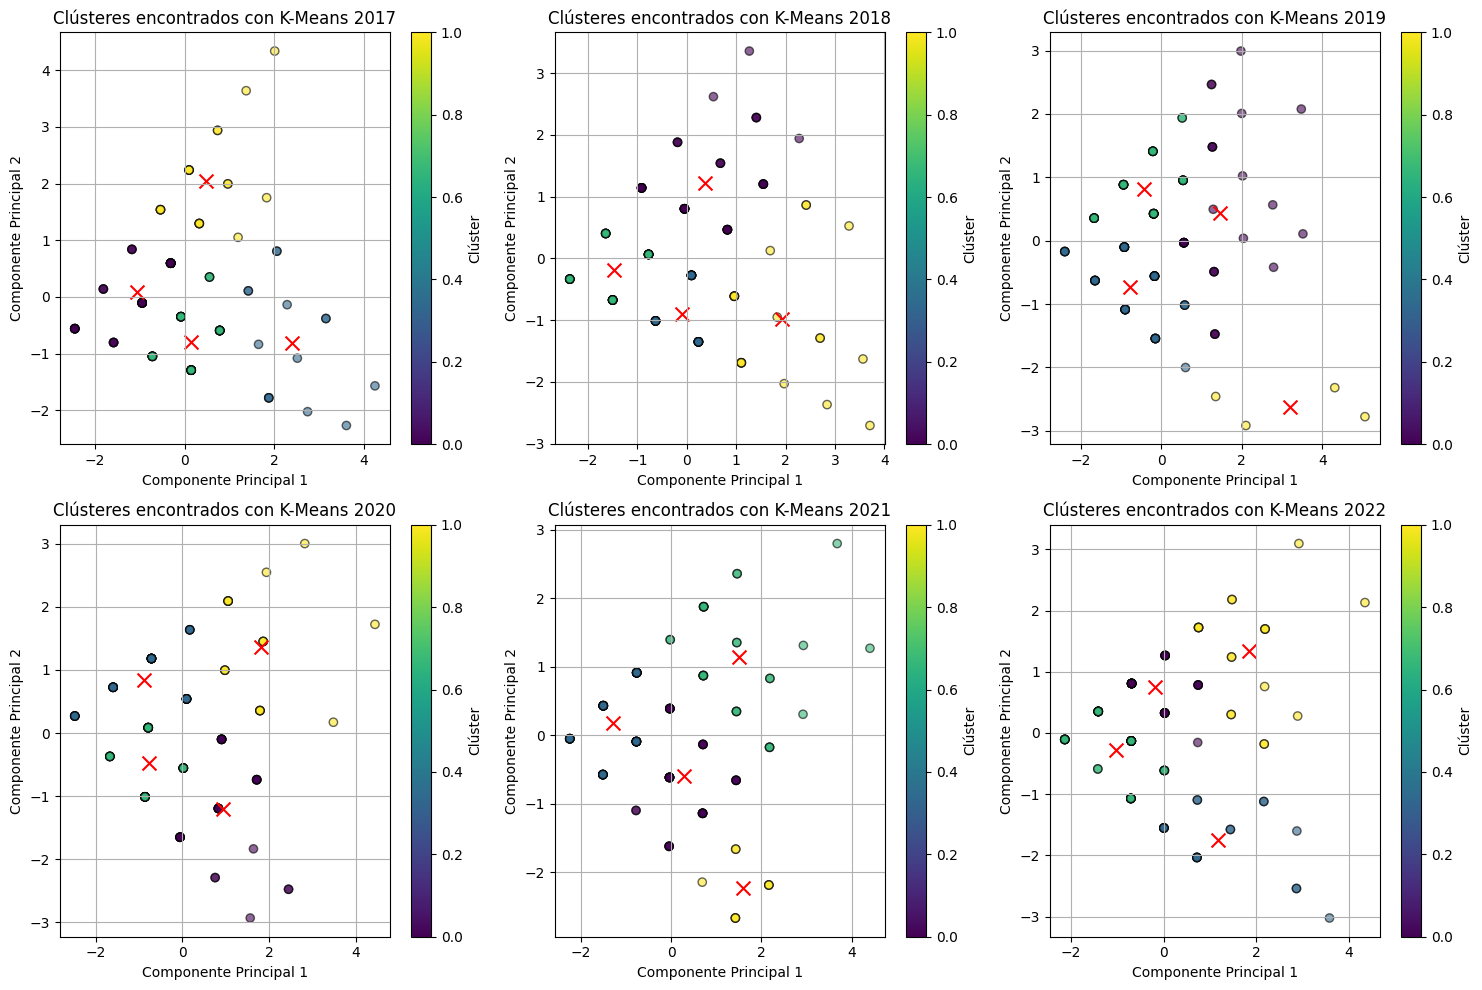

In [15]:
# Lista de DataFrames
csvs = [df_2017, df_2018, df_2019, df_2020, df_2021, df_2022]

# Crear una nueva figura
plt.figure(figsize=(15, 10))

# Iterar sobre cada DataFrame
for i, df in enumerate(csvs, start=1):
    # Eliminar columnas no numéricas o no relevantes para PCA
    df_numeric = df.drop(columns=['Match Number', 'Round Number', 'Result', 'Winner', 'Home Team', 'Away Team'])

    # Escalar características numéricas
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_numeric)

    # Reducción de dimensionalidad con PCA
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_scaled)

    # Clústering con K-Means
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(df_pca)
    labels = kmeans.labels_

    # Posicionamiento de la sub-figura
    plt.subplot(2, 3, i)
    
    # Visualización de resultados
    plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.6)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
    plt.title(f'Clústeres encontrados con K-Means {i+2016}')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.colorbar(label='Clúster')
    plt.grid(True)

# Ajustar el diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

Ahora vamos a probar a hacer el clustering según otros algoritmos como Mean_Shift, Mini-Batch K-Means, DBScans, OPTICS, GMM, Agglomerative Clustering:

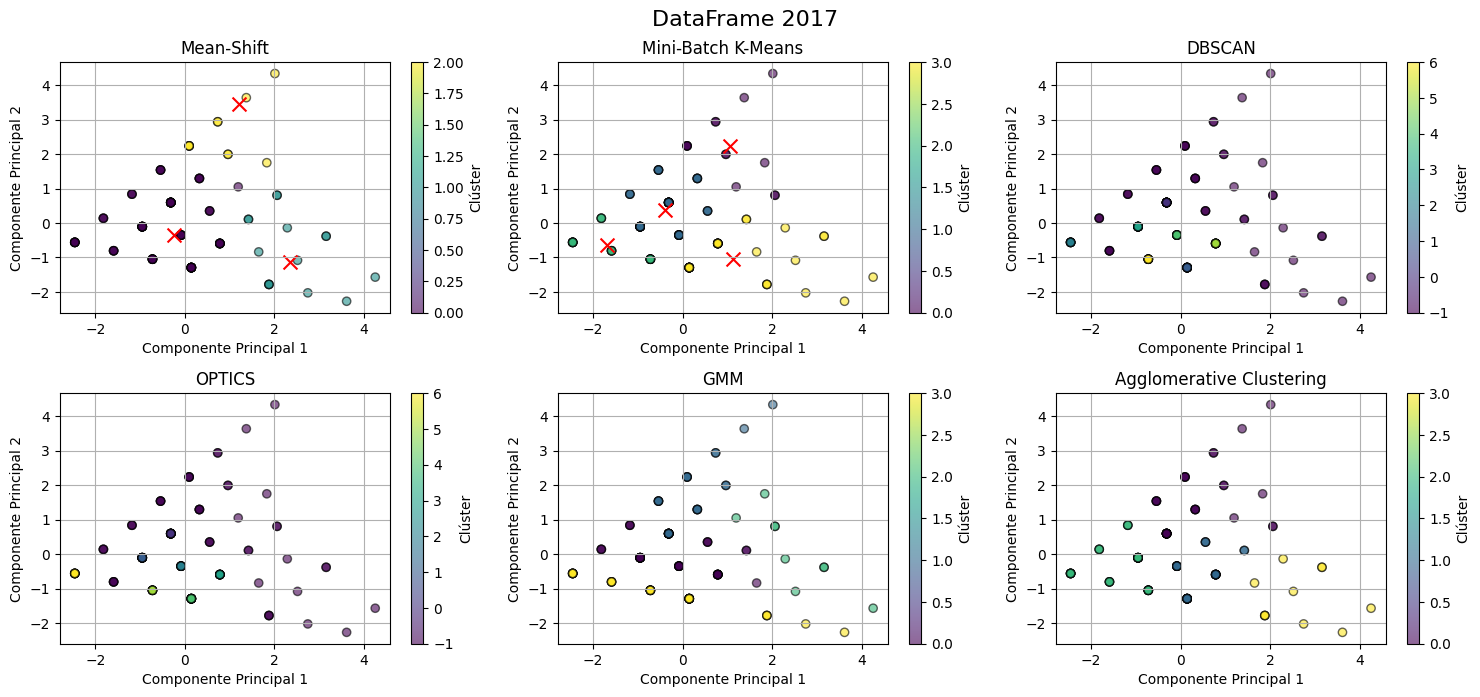

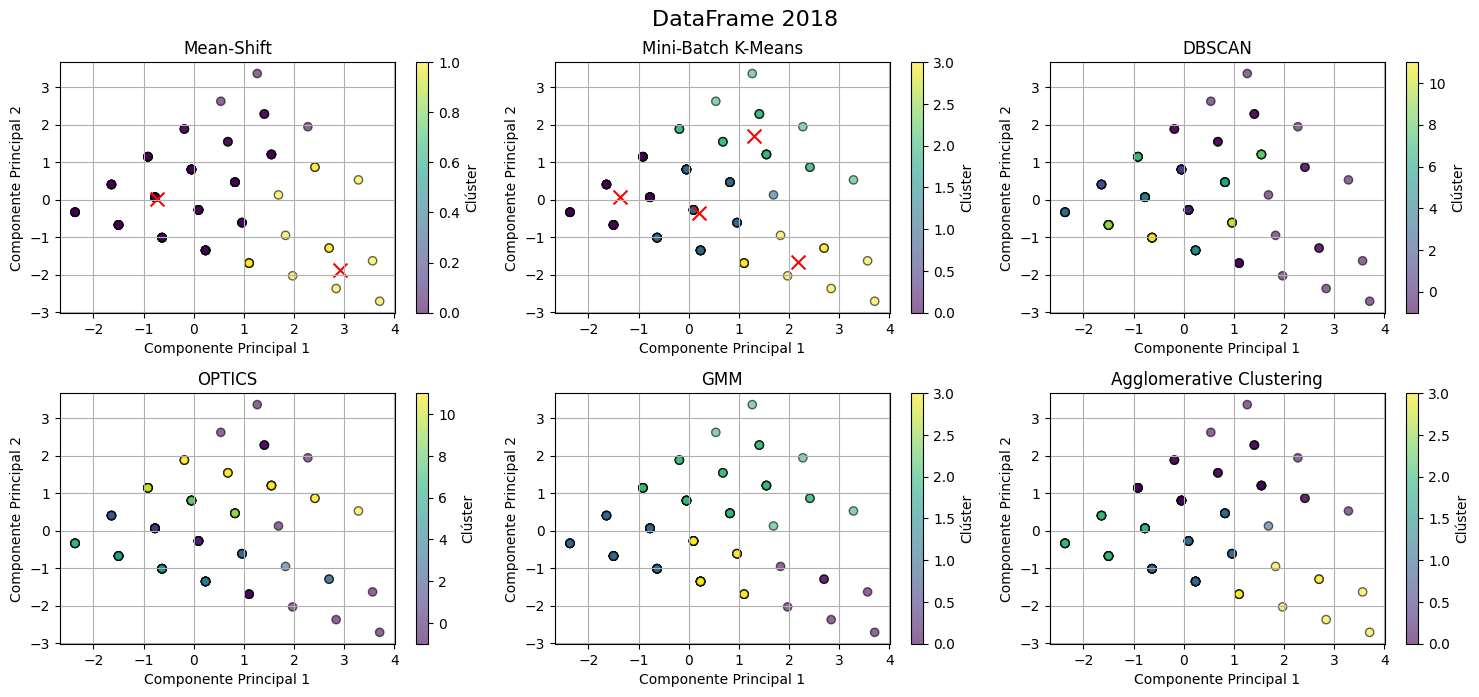

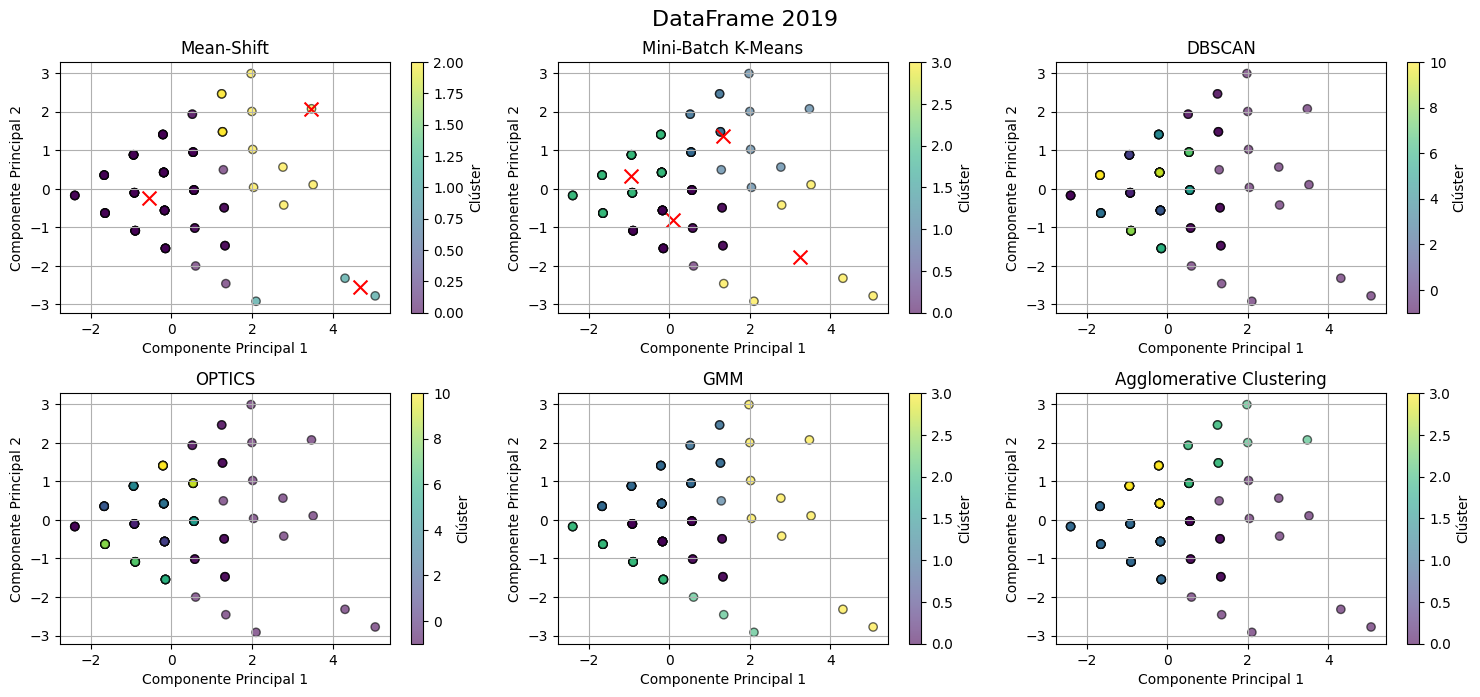

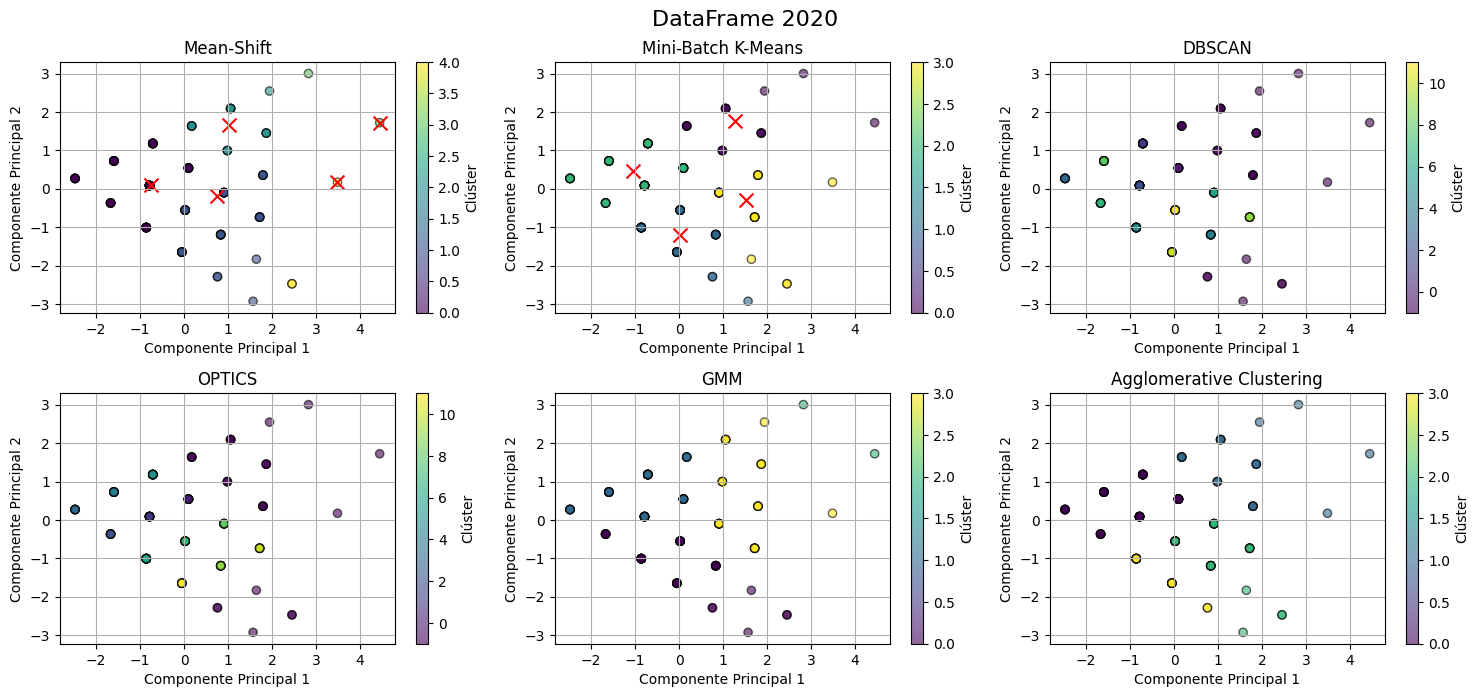

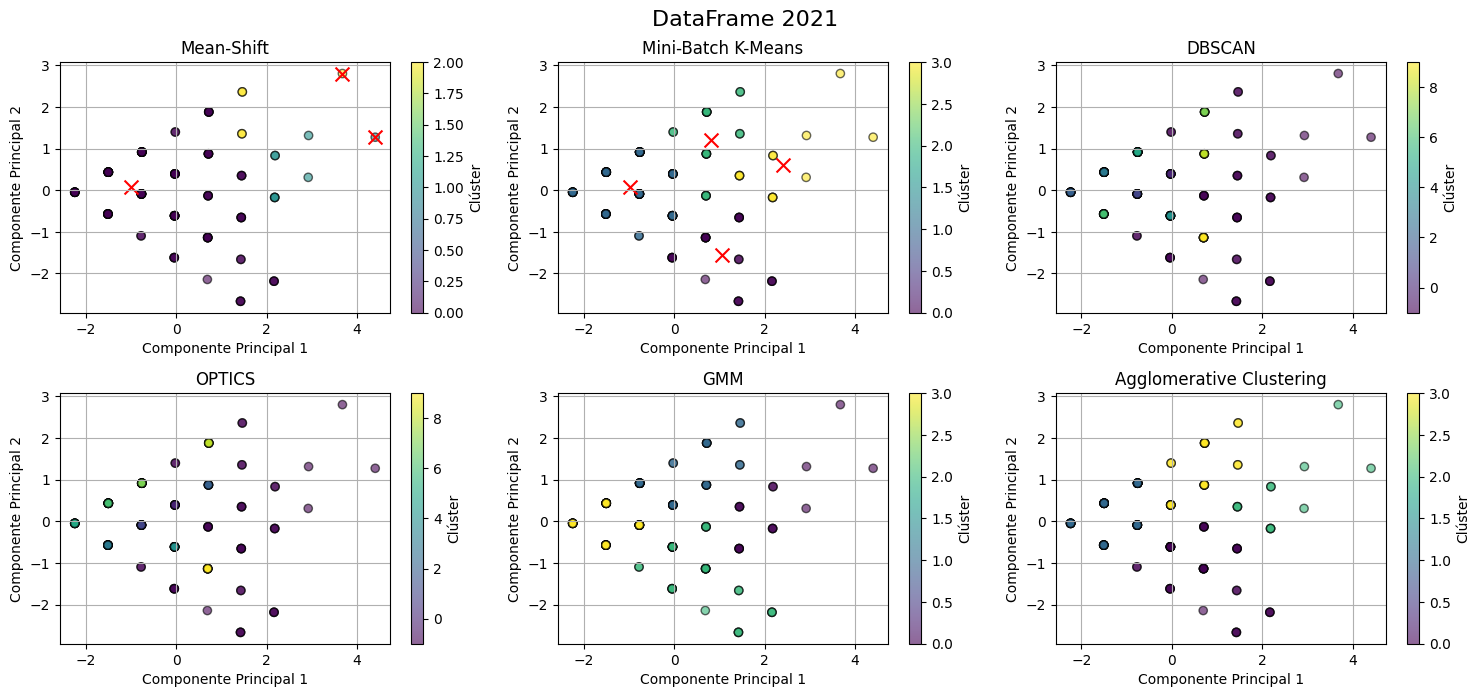

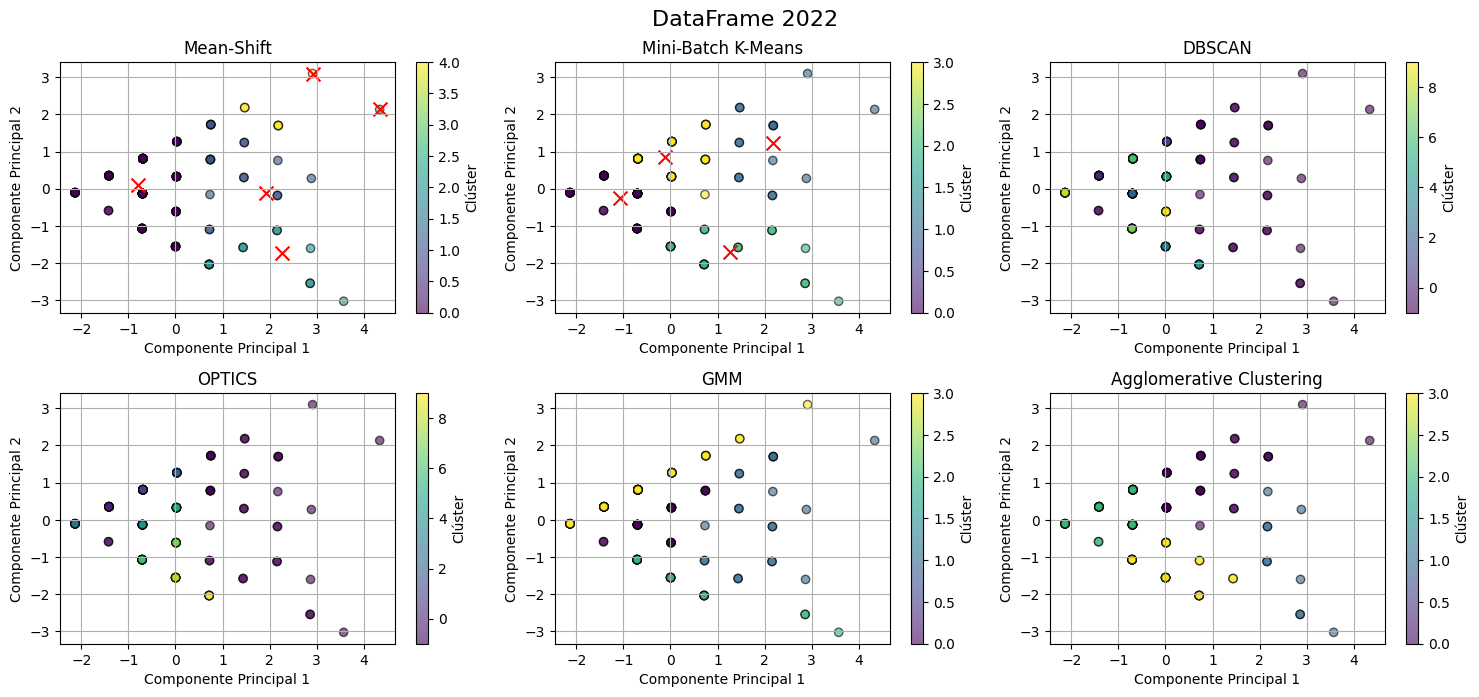

In [16]:
import warnings

# Desactivar RuntimeWarnings temporalmente
warnings.filterwarnings("ignore", category=RuntimeWarning)


# Definir los nombres de los algoritmos de clustering
algorithms = {
    "Mean-Shift": MeanShift(),
    "Mini-Batch K-Means": MiniBatchKMeans(n_clusters=4),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "OPTICS": OPTICS(),
    "GMM": GaussianMixture(n_components=4),
    "Agglomerative Clustering": AgglomerativeClustering(n_clusters=4)
}

# Iterar sobre cada DataFrame
for i, df in enumerate(csvs):
    # Reducción de dimensionalidad con PCA
    scaler = StandardScaler()
    df_numeric = df.drop(columns=['Match Number', 'Round Number', 'Result', 'Winner', 'Home Team', 'Away Team'])
    df_scaled = scaler.fit_transform(df_numeric)
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_scaled)

    # Iterar sobre cada algoritmo de clustering
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'DataFrame {i+2017}', fontsize=16)
    for j, (name, algorithm) in enumerate(algorithms.items(), 1):
        algorithm.fit(df_pca)
        if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
        else:
            labels = algorithm.predict(df_pca)
        
        # Visualización de resultados
        plt.subplot(3, 3, j)
        plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.6)
        plt.title(name)
        plt.xlabel('Componente Principal 1')
        plt.ylabel('Componente Principal 2')
        plt.colorbar(label='Clúster')
        if hasattr(algorithm, 'cluster_centers_'):
            plt.scatter(algorithm.cluster_centers_[:, 0], algorithm.cluster_centers_[:, 1], c='red', marker='x', s=100)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Reactivar RuntimeWarnings
warnings.filterwarnings("default", category=RuntimeWarning)

Con toda esta información podemos visualizar un patrón en cada Champions pasada. Lo primero es identificar que nos está diciendo cada gráfica. Cuando se utiliza PCA (Análisis de Componentes Principales) para reducir la dimensionalidad de los datos, los componentes principales se denominan comúnmente "Componente Principal 1" (PC1) y "Componente Principal 2" (PC2), y se refieren a las nuevas dimensiones que se crean después de la reducción de dimensionalidad. Son combinaciones lineales de las características originales en los datos y representan direcciones en el espacio de características donde los datos tienen la mayor variabilidad.

Por lo tanto, cuando se visualizan los datos en un gráfico de dispersión utilizando PC1 y PC2 en los ejes x e y estamos viendo cómo los datos se distribuyen en el espacio definido por estas dos direcciones de máxima variabilidad.

En este caso los algoritmos en los que nos vamos a centrar son K-means, Mini-Batch K-means, GMM y Agglomerative Clustering. Estos algoritmos son los que nos proporcionan un patrón más claro de separación entre clusteres, cada uno con su propia definición.

Analizando las gráficas podemos notar que los clústeres con los valores más altos provienen de los últimos años 2020 y 2021, dando a entender que los goles por champions aumentaron notablemente. Esto es algo que analizaremos más a continuación usando el ranking UEFA y los goles de cada equipo de forma exclusiva durante los últimos 7 años.

Proseguimos llevando a cabo el mismo estudio pero esta vez asociado al ranking UEFA y los goles de cada equipo los últimos 7 años:

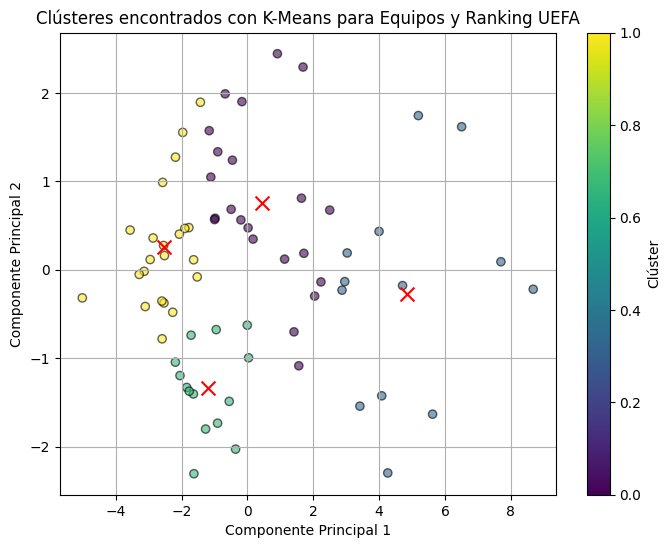

In [17]:
# Renombrar columna en df_equipos_goles
df_equipos_goles.rename(columns={'Equipo': 'Club'}, inplace=True)

# Unir los DataFrames en base a la columna 'Club'
df_combined = pd.merge(df_equipos_goles, df_uefa_ranking, on='Club')

# Eliminar la columna 'Club' antes de aplicar PCA
df_combined_numeric = df_combined.drop(columns=['Club'])

# Imputar valores perdidos con 0
imputer = SimpleImputer(strategy='constant', fill_value=0)
df_imputed = imputer.fit_transform(df_combined_numeric)

# Escalar características numéricas
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_imputed)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Clústering con K-Means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_pca)
labels = kmeans.labels_

# Visualización de resultados
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
plt.title('Clústeres encontrados con K-Means para Equipos y Ranking UEFA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Clúster')
plt.grid(True)
plt.show()

Probamos también con los demás algortimos para posteriormente sacar las conclusiones necesarias:

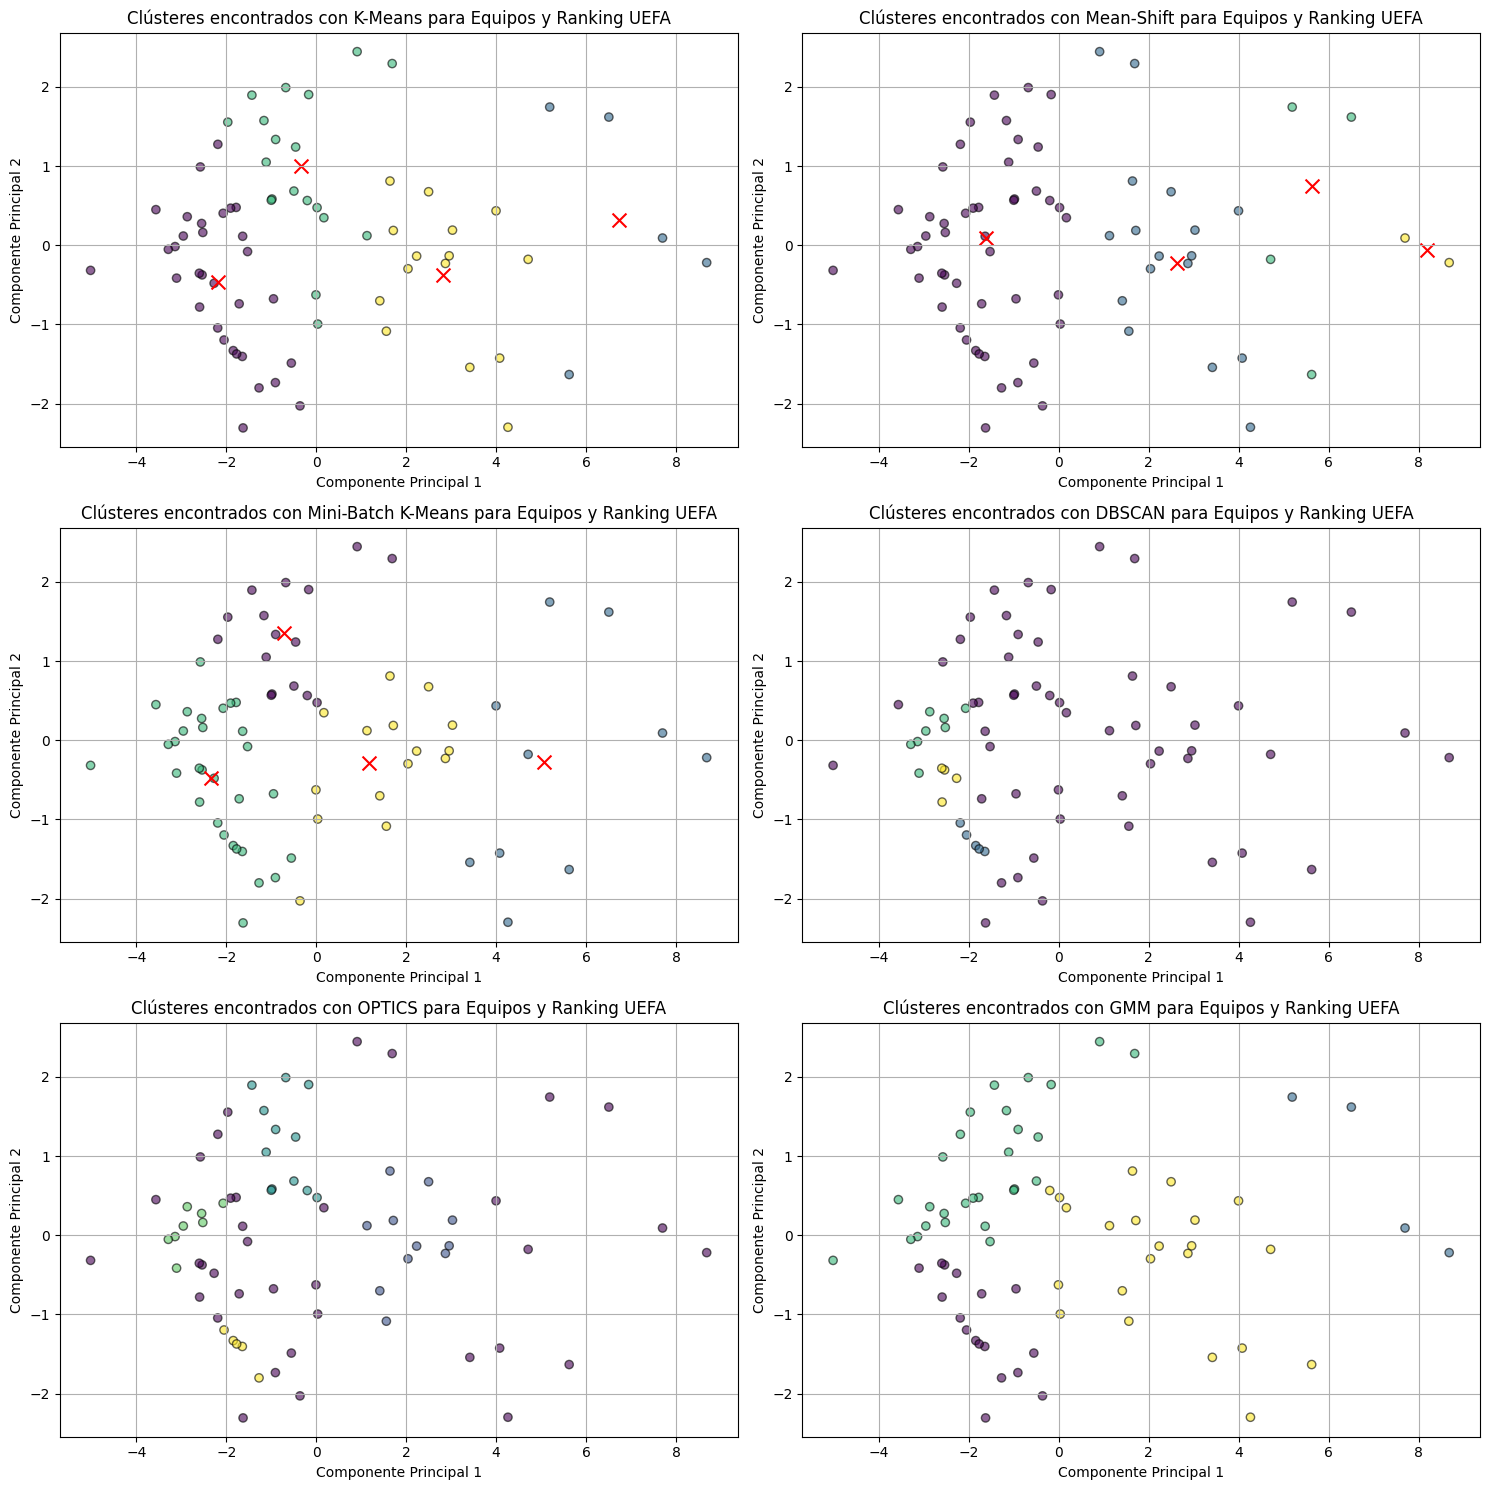

In [18]:
# Diccionario de algoritmos de clústering
algorithms = {
    "K-Means": KMeans(n_clusters=4),
    "Mean-Shift": MeanShift(),
    "Mini-Batch K-Means": MiniBatchKMeans(n_clusters=4),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "OPTICS": OPTICS(),
    "GMM": GaussianMixture(n_components=4),
    "Agglomerative Clustering": AgglomerativeClustering(n_clusters=4)
}

# Crear subgráficos para mostrar los resultados de todos los algoritmos en la misma ventana de visualización
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.ravel()

for ax, (name, algorithm) in zip(axs, algorithms.items()):
    algorithm.fit(df_pca)
    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(df_pca)
    
    # Visualización de resultados
    ax.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.6)
    if hasattr(algorithm, 'cluster_centers_'):
        ax.scatter(algorithm.cluster_centers_[:, 0], algorithm.cluster_centers_[:, 1], c='red', marker='x', s=100)
    ax.set_title(f'Clústeres encontrados con {name} para Equipos y Ranking UEFA')
    ax.set_xlabel('Componente Principal 1')
    ax.set_ylabel('Componente Principal 2')
    ax.grid(True)

plt.tight_layout()
plt.show()

Es evidente que los clusters más grandes se encuentran centrados en las gráficas, representando al conjunto general de equipos en la Champions. También tenemos un cluster más reducido en los puntos altos muy parecido a los extraídos anteriormente con cada torneo que representan a los equipos con más victorias goles y por tanto puntuación (ya vimos en la regresión lineal que están conectados). 

Vamos a ver que pasa con los cluster si metemos además las victorias de champions y los partidos ganados:

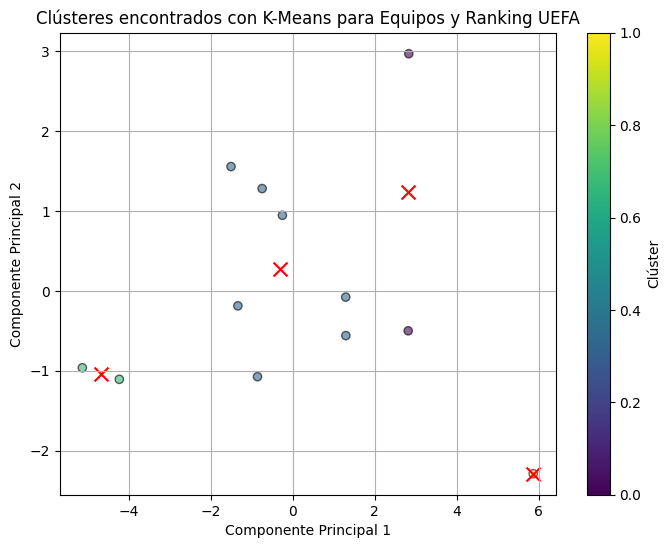

In [19]:
# Renombrar columna en df_equipos_goles
df_equipos_goles.rename(columns={'Equipo': 'Club'}, inplace=True)
df_victorias.rename(columns={'Equipo': 'Club'}, inplace=True)
df_champions.rename(columns={'Equipo': 'Club'}, inplace=True)

# Unir los DataFrames en base a la columna 'Club'
df_combined = pd.merge(df_equipos_goles, df_uefa_ranking, on='Club')
df_combined = pd.merge(df_combined, df_victorias, on='Club')
df_combined = pd.merge(df_combined, df_champions, on='Club')

# Eliminar la columna 'Club' antes de aplicar PCA
df_combined_numeric = df_combined.drop(columns=['Club'])

# Imputar valores perdidos con 0
imputer = SimpleImputer(strategy='constant', fill_value=0)
df_imputed = imputer.fit_transform(df_combined_numeric)

# Escalar características numéricas
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_imputed)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Clústering con K-Means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_pca)
labels = kmeans.labels_

# Visualización de resultados
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
plt.title('Clústeres encontrados con K-Means para Equipos y Ranking UEFA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Clúster')
plt.grid(True)
plt.show()

Los demás algoritmos quedarían de la siguiente forma:

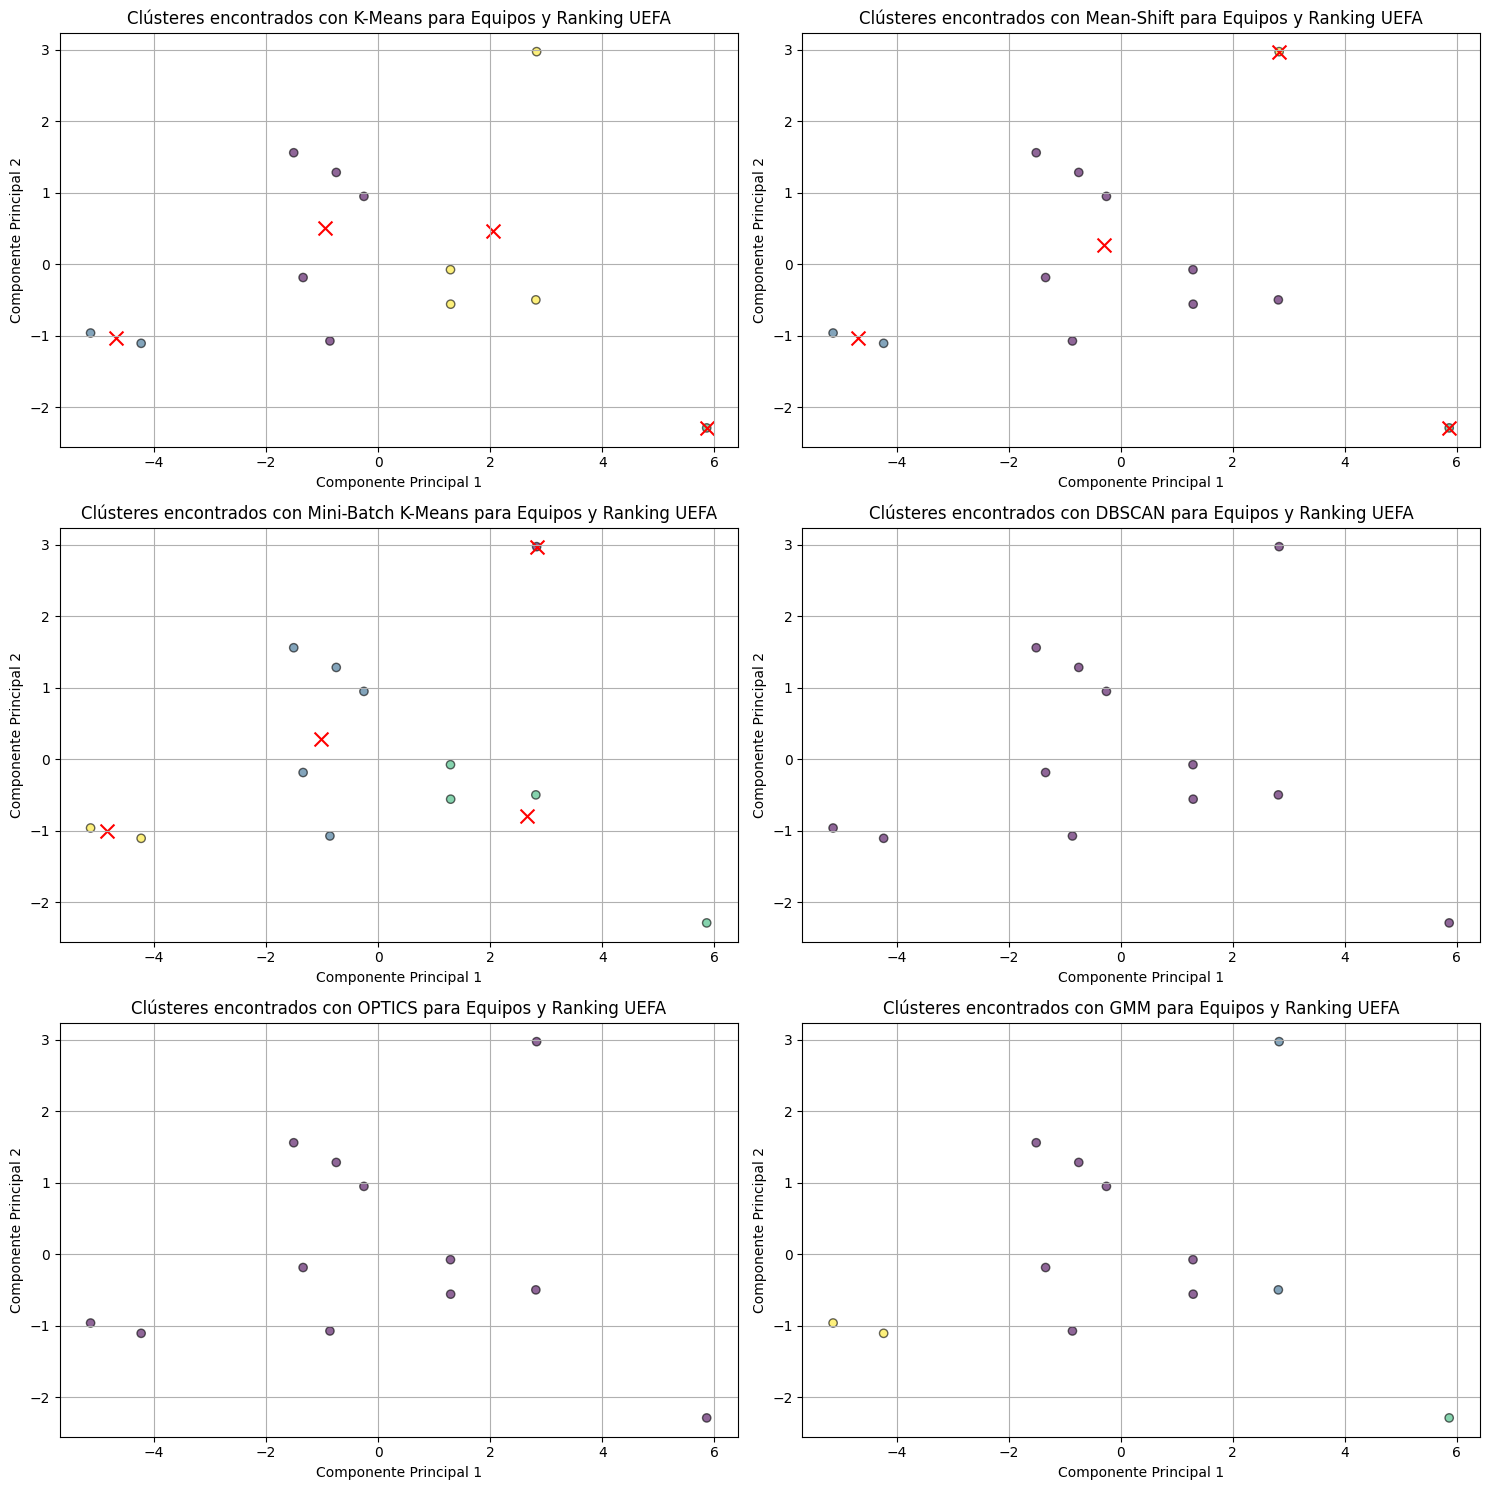

In [20]:
# Diccionario de algoritmos de clústering
algorithms = {
    "K-Means": KMeans(n_clusters=4),
    "Mean-Shift": MeanShift(),
    "Mini-Batch K-Means": MiniBatchKMeans(n_clusters=4),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "OPTICS": OPTICS(),
    "GMM": GaussianMixture(n_components=4),
    "Agglomerative Clustering": AgglomerativeClustering(n_clusters=4)
}

# Crear subgráficos para mostrar los resultados de todos los algoritmos en la misma ventana de visualización
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.ravel()

for ax, (name, algorithm) in zip(axs, algorithms.items()):
    algorithm.fit(df_pca)
    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(df_pca)
    
    # Visualización de resultados
    ax.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.6)
    if hasattr(algorithm, 'cluster_centers_'):
        ax.scatter(algorithm.cluster_centers_[:, 0], algorithm.cluster_centers_[:, 1], c='red', marker='x', s=100)
    ax.set_title(f'Clústeres encontrados con {name} para Equipos y Ranking UEFA')
    ax.set_xlabel('Componente Principal 1')
    ax.set_ylabel('Componente Principal 2')
    ax.grid(True)

plt.tight_layout()
plt.show()

Como se puede apreciar los clusteres se reducen mucho ya que los datos empiezan a presentar grandes disparidades debido a los pocos equipos que han ganado champions y la gran diferencia de victorias durante los últimos 7 años en partidos de los grandes equipos con el resto de equipos.

Centrándonos en K-means vemos que hay 4 clusters que representan:


    -El verde a los equipos que no han ganado nada o no han estado presentes en las últimas Champions
    -El morado el conjunto normal de equipos que están en la media
    -El azul grisáceo el conjunto de equipos con buenos resultados
    -El amarillo el conjunto de equipos con una gran diferencia entre los parámetros recogidos en el cluster, como podría ser ranking UEFA y número de victorias de Champions

Finalmente vamos a analizar cada equipo en el tiempo y formar nuevos clusters usando UEFA_Ranking, que es el único csv que recoje de alguna forma la puntuación de cada equipo en el tiempo. Nos es de utilidad ya que esta puntuación está basada en una combinación lineal de factores que ya hemos analizado por separado, como los goles, las victorias, la preparación de cada equipo...

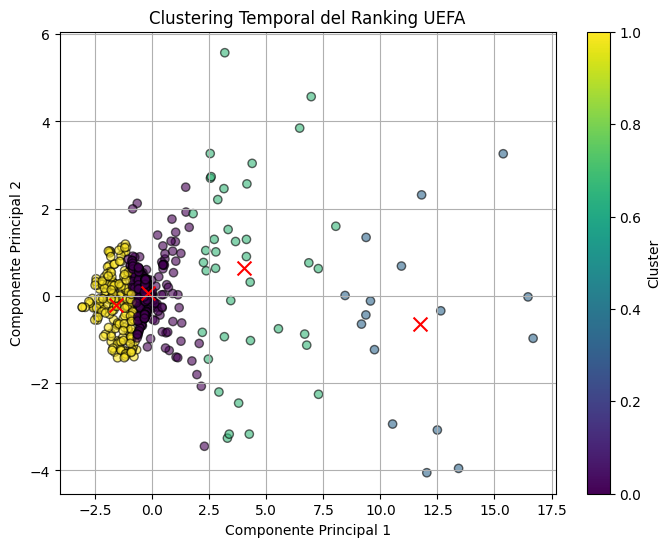

In [21]:
# Cargar el DataFrame del ranking UEFA
df_uefa_ranking = pd.read_csv('data/UEFA_Ranking.csv')

# Extraer las columnas de las fechas y las puntuaciones
fechas = df_uefa_ranking.columns[2:-2]
puntuaciones = df_uefa_ranking.iloc[:, 2:-2].values

# Reemplazar valores NaN con la media de la columna
imputer = SimpleImputer(strategy='mean')
puntuaciones_imputed = imputer.fit_transform(puntuaciones)

# Escalar las puntuaciones
scaler = StandardScaler()
puntuaciones_scaled = scaler.fit_transform(puntuaciones_imputed)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
puntuaciones_pca = pca.fit_transform(puntuaciones_scaled)

# Clustering con K-Means
kmeans = KMeans(n_clusters=4)
kmeans.fit(puntuaciones_pca)
labels = kmeans.labels_

# Visualización de resultados
plt.figure(figsize=(8, 6))
plt.scatter(puntuaciones_pca[:, 0], puntuaciones_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
plt.title('Clustering Temporal del Ranking UEFA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


Esta gráfica nos agrupa en 4 clusters la puntuación UEFA obtenida desde 14/15 hasta el 23/24. Vemos que es bastante parecida a los clusters obtenidos individualmente y en conjunto antes.

Seguimos tratando de realizar un pronóstico con ARIMA con estos datos:

Error cuadrático medio: 251.6007794336709


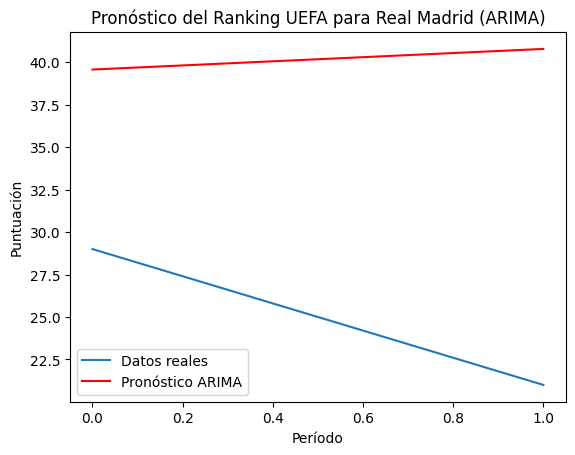

In [22]:
# Desactivar RuntimeWarnings temporalmente
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Filtrar los ConvergenceWarnings y RuntimeWarnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


# Pronóstico con ARIMA para un club específico (ejemplo: Real Madrid)
indice_real_madrid = df_uefa_ranking[df_uefa_ranking['Club'] == 'Real Madrid'].index[0]
serie_temporal_real_madrid = puntuaciones[indice_real_madrid]

# Dividir los datos en entrenamiento y prueba
train_size = int(len(serie_temporal_real_madrid) * 0.8)
train, test = serie_temporal_real_madrid[:train_size], serie_temporal_real_madrid[train_size:]

# Entrenar el modelo ARIMA
modelo_arima = ARIMA(train, order=(5,1,0))  # Ejemplo de orden (p,d,q)
modelo_arima_entrenado = modelo_arima.fit()

# Realizar pronósticos
pronostico_arima = modelo_arima_entrenado.forecast(steps=len(test))

# Calcular el error cuadrático medio
mse = mean_squared_error(test, pronostico_arima)
print('Error cuadrático medio:', mse)

# Visualizar los resultados
plt.plot(test, label='Datos reales')
plt.plot(pronostico_arima, color='red', label='Pronóstico ARIMA')
plt.title('Pronóstico del Ranking UEFA para Real Madrid (ARIMA)')
plt.xlabel('Período')
plt.ylabel('Puntuación')
plt.legend()
plt.show()

Lo analizaremos después de compararlo con el resto de métricas: Exponential Smoothing, SARIMAX y Random Forest

Error cuadrático medio (Exponential Smoothing): 40.99999938641956


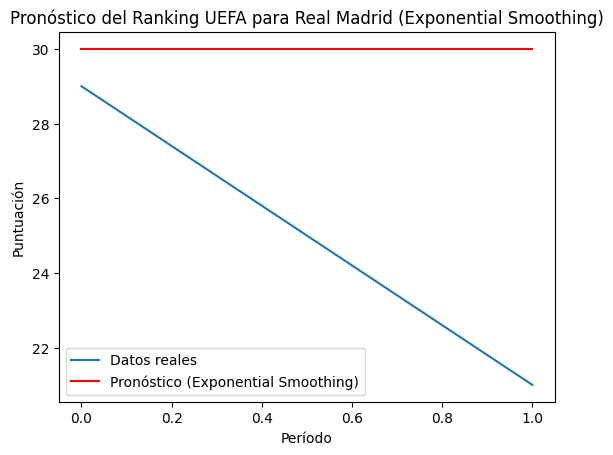

Error cuadrático medio: 251.6007794336709


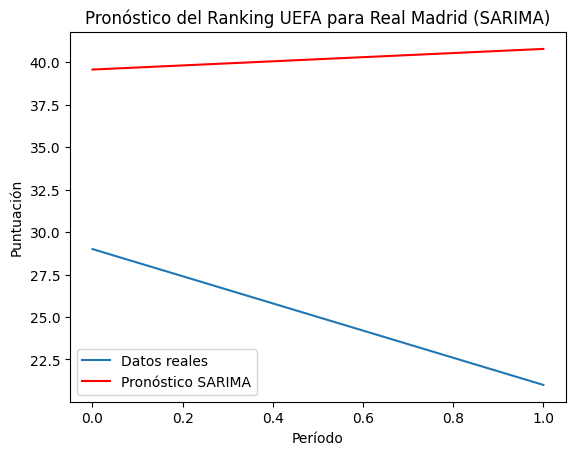

Error cuadrático medio (Random Forest): 59.81439999999999


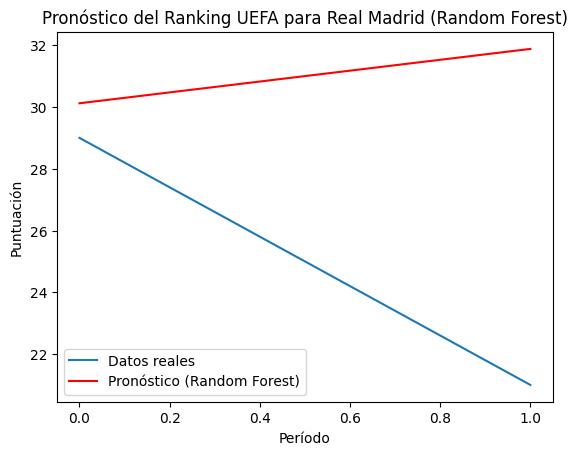

In [23]:

# Pronóstico con Exponential Smoothing para un club específico (ejemplo: Real Madrid)
indice_real_madrid = df_uefa_ranking[df_uefa_ranking['Club'] == 'Real Madrid'].index[0]
serie_temporal_real_madrid = puntuaciones[indice_real_madrid]

# Dividir los datos en entrenamiento y prueba
train_size = int(len(serie_temporal_real_madrid) * 0.8)
train, test = serie_temporal_real_madrid[:train_size], serie_temporal_real_madrid[train_size:]

# Entrenar el modelo Exponential Smoothing
modelo_es = SimpleExpSmoothing(train).fit()

# Realizar pronósticos
pronostico_es = modelo_es.forecast(len(test))

# Calcular el error cuadrático medio
mse = mean_squared_error(test, pronostico_es)
print('Error cuadrático medio (Exponential Smoothing):', mse)

# Visualizar los resultados de Exponential Smoothing
plt.plot(test, label='Datos reales')
plt.plot(pronostico_es, color='red', label='Pronóstico (Exponential Smoothing)')
plt.title('Pronóstico del Ranking UEFA para Real Madrid (Exponential Smoothing)')
plt.xlabel('Período')
plt.ylabel('Puntuación')
plt.legend()
plt.show()

# Pronóstico con SARIMA para un club específico (ejemplo: Real Madrid)
# Se puede implementar de manera similar a ARIMA
indice_real_madrid = df_uefa_ranking[df_uefa_ranking['Club'] == 'Real Madrid'].index[0]
serie_temporal_real_madrid = puntuaciones[indice_real_madrid]

# Dividir los datos en entrenamiento y prueba
train_size = int(len(serie_temporal_real_madrid) * 0.8)
train, test = serie_temporal_real_madrid[:train_size], serie_temporal_real_madrid[train_size:]

# Entrenar el modelo SARIMA
modelo_arima = SARIMAX(train, order=(5,1,0))  # Ejemplo de orden (p,d,q)
modelo_arima_entrenado = modelo_arima.fit()

# Realizar pronósticos
pronostico_arima = modelo_arima_entrenado.forecast(steps=len(test))

# Calcular el error cuadrático medio
mse = mean_squared_error(test, pronostico_arima)
print('Error cuadrático medio:', mse)

# Visualizar los resultados
plt.plot(test, label='Datos reales')
plt.plot(pronostico_arima, color='red', label='Pronóstico SARIMA')
plt.title('Pronóstico del Ranking UEFA para Real Madrid (SARIMA)')
plt.xlabel('Período')
plt.ylabel('Puntuación')
plt.legend()
plt.show()

# Pronóstico con Random Forest para un club específico (ejemplo: Real Madrid)
# Entrenar el modelo Random Forest
modelo_rf = RandomForestRegressor()
modelo_rf.fit(np.arange(len(train)).reshape(-1, 1), train)

# Realizar pronósticos
pronostico_rf = modelo_rf.predict(np.arange(len(test)).reshape(-1, 1))

# Calcular el error cuadrático medio
mse = mean_squared_error(test, pronostico_rf)
print('Error cuadrático medio (Random Forest):', mse)

# Visualizar los resultados de Random Forest
plt.plot(test, label='Datos reales')
plt.plot(pronostico_rf, color='red', label='Pronóstico (Random Forest)')
plt.title('Pronóstico del Ranking UEFA para Real Madrid (Random Forest)')
plt.xlabel('Período')
plt.ylabel('Puntuación')
plt.legend()
plt.show()

# Reactivar RuntimeWarnings y ConvergenceWarnings
warnings.filterwarnings("default", category=RuntimeWarning)
warnings.filterwarnings("default", category=ConvergenceWarning)

En este caso lo que estamos tratando de predecir es la puntuación a lo largo del tiempo que tendrá el REAL MADRID según la UEFA. Es curioso como los datos reales simulan un descenso progresivo según pasa el tiempo (estos están basados solo en las puntuaciones pasadas) ya que las puntuaciones otorgadas en los años 14/15 15/16 son superiores a la de los años recientes, mientras que el modelo entrenado con los datos totales estima un aumento ligero y gradual de ellos contra todo pronóstico en todos los algoritmos. Ninguna métrica es incorrecta ya que es cierto que la puntuación va disminuyendo debido al aumento de calidad del resto de los equipos con los años a la vez que este equipo (REAL MADRID) sigue mejorando individualmente.

Esta información nos da a entender que un equipo, en este ejemplo el REAL MADRID, cuya puntuación parece que disminuye con el tiempo mejorará según el análisis y predicción según pasen los años.

Sería interesante realizar este mismo análisis con el resto de equipos, pero de momento esta primera exploración nos vale para entender como evolucionarán nuestros datos en conjunto.

Por supuesto no podemos fiarnos del todo de todas las predicciones. Como dice nuestro error cuadrático medio, las realizadas por SARIMAX y ARIMA son muy poco precisas, por lo tanto inútiles en lo que a futuro respecta. Random forest y Exponential Smoothing tampoco son muy precisas, pero si nos ayudan a hacernos una idea de por donde van los tiros.